# CS171 - Winter 2022 - Extra Credit Assignment: 
# Unsupervised Analysis of a Movie Ratings Dataset Using Matrix Factorization
### Instructor: Vagelis Papalexakis
### TA: Yorgos Tsitsikas
### Credit: 10/100 points of the final grade

In this extra credit assignment we will explore a family of unsupervised learning tools called Matrix Factorization, and apply it a version of the famous MovieLens dataset (https://grouplens.org/datasets/movielens/), developed by the University of Minnesota and largely pioneered the field of recommendation systems. For the purposes of this assignment, we will focus on a small version of this dataset which can be downloaded here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip (and the associated README: http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). 

In particular, we are going to form a (movie, user) matrix, which will hold the rating that each user gave to a particular movie. Since we have meta-data for the movies (including title, genre(s), and data), we are going to treat the movies as our primary data points of interest and treat the users as features, and we will explore the space of movies in an unsupervised manner. Typically, however, both movies and users are treated as primary data points in this problem definition, since a platform that offers movies and wants to leverage movie ratings will want to understand both the movies and the users (preferrably in combination).

As we saw in class, the Singular Value Decomposition (SVD) is the most popular method in this family, and for good reason, since it can provably approximate a data matrix (e.g., where the rows are the data points and the columns are the features) optimally (when measuring the squared error between the approximation and the original data) in a smaller dimension. The above process is called low rank approximation and is a fundamental approach in dimensionality reduction. 

During low rank approximation, using some sort of matrix factorization (e.g., the SVD), we are forcing the potentially very high-dimensional data points in our dataset (i.e., rows of the matrix) to occupy a much smaller-dimensional space. By doing so, we implicitly assume that even though data points (movies in our case) may "live" in a very high-dimensional feature space (in our case, every user is a feature and the rating they gave the movie is the value for that feature, amounting to hundreds of features), in reality each movie "lives" in a much smaller space, e.g., the space of genres. Since we are working with movies, we typically have some genre information already available. However, what this low rank approximation can reveal to us is groupings of movies in new "genres" which are discovered from the data and reflect the manner in which different users appear to enjoy the movies in that "genre" similarly. In that sense, we do not necessarily expect those data-driven "genres" to directly map to the pre-determined genre classification of a particular movie, however, it would make a lot of sense if most of them do. We often call those "genres" "latent concepts" because they are initially hidden in the large dimensionality of the data, but they are uncovered by the low rank approximation.

In this assignment we will use two different matrix factorization techniques:
- Singular Value Decomposition (SVD): As we saw in class, this is the optimal we can do in terms of squared error. However, there are some drawbacks here, since the SVD can have negative values, especially in cases where latent concepts ("genres") overlap, making our life harder when it's time to try to interpret the membership of each movie to latent concept.
- Non-negative Matrix Factorization (NMF): NMF is a constrained matrix factorization, where the factor matrices (representing the mappings of movie to latent concept and user to latent concept) have non-negative values. This is extremely important in cases such as in this assignment, where we need to inspect and interpret the results. The following, highly-influential paper in Nature describes NMF very succinctly: https://www.nature.com/articles/44565

## Question 0: Loading the data [0%]
First we have to load the data in a format that we can process. For this, please download http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
There are several .csv files in that folder, but the ones we will focus on for this assignment are 1) 'ratings.csv', which holds the ratings that each user gave each movie, and 2) 'movies.csv', which holds the movie meta-data that will be useful to us so that we judge the quality of the discovered "genres".

Make sure you can load those two files and familiarize yourself with the format of each of the files. You may use functionality from Pandas (e.g., DataFrame) as in the previous assignments.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
#please don't change the path below
data = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

## Question 1: Forming the matrix [25%]
After loading the data, the first thing we must do is form a (movie, user) matrix. The matrix to be formed should preferrably be a Numpy object (however, if you find a different way of doing so, and the whole assignment works, as long as you document what you did, you will receive full credit).

There are a couple of caveats to be aware of here:
- The movieId column in the data refers to a general movieId in the large MovieLens dataset. Since we are working with the smaller dataset here, we do not have all movieId's present. Thus, you should be able to make sure that a certain movieId maps to an increasing row number of your matrix and you keep track of that mapping
- The userId column, since user information is not present, can be treated as a unique user ID.
- If for some reason Pandas is not able to load all the rows of the ratings.csv in memory, please form a matrix with as many ratings as you are able to load.

In [2]:
#sort by movieId so that the movie will be easily accessible later on
data.sort_values(by='movieId', inplace=True)

#generate the matrix
matrix = np.array(pd.pivot_table(data, values='rating', index='movieId', columns='userId', fill_value=0).values)

## Question 2: Running and inspecting the SVD [25%]
After forming a matrix, we are now ready to run the Singular Value Decomposition! In order to do so, please study carefully the documentation of the Numpy implementation of the SVD (https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) and run the SVD for the data matrix you formed.

As we saw in class, the singular values, which are by convention sorted in descending order, give us the importance of the latent concepts (each singular value corresponds to a latent concept in the data). Thus, by inspecting the singular values in our data, we can see whether there is a number of latent concepts/singular values that are overwhelmingly higher than the rest. In those cases, that number of singular values signifies what we call the low rank of the data, i.e., the number of singular values that, if used, can approximate most of the original data adequately, while forcing movies (and users) which behave similarly in the data to be represented by the same latent concept.

After running the SVD, plot in a semi-logarithmic scale (where the y-axis is in log scale and the x-axis is in linear scale) the singular values of the matrix. What do you observe?


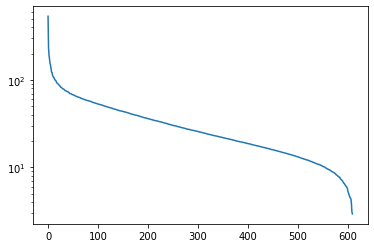

In [3]:
u, s, vh = np.linalg.svd(matrix)
plt.semilogy(s);

(Your answer here): Looking at the graph, the graph drops significantly at the beginning and steadily goes down in the middle. This means that the first 10 or 15 singular values are higher than the rest and they can be used to approximate most of the original data adequately.

## Question 3: Inspecting the latent concepts [25%]
Now it is time to inspect the "genres" / latent concepts. The easiest way to do so is the following: The columns of matrix $U$ correspond to our latent concepts. For each latent concept (say the $j$-th one), we can retrieve the membership of every movie to that concept. This membership vector is the $j$-th column of the $U$ matrix of the SVD. Thus, if we take the $j$-th column of U, the $i$-th value in that vector represents the degree to which the $i$-th movie "belongs" to that concept. In order to characterize the concept, we can, thus, take the top-k movies per concept, ranked in descending order by their value in that vector, and visually inspect them.

In this question, you should make a function 
```python
def print_concepts(U,num_of_concepts,top_mov):
```
which takes as input 1) the movie-to-concept matrix $U$, 2) the number of desired concepts, and 3) the number of top movies per concept, and prints the list of top movies per concept (please include title and genre).

Finally, in order to avoid negative values, take the absolute value of each entry of the above membership vector. This is a rather ad-hoc but popular choice, however, NMF directly addresses that problem by imposing non-negativity constraints in the model.


In [4]:
def print_concepts(U, num_of_concepts, top_mov):
    ids = data['movieId'].unique().tolist()
    for i in range(num_of_concepts):
        print('Latent Concept', i + 1)
        tops = np.argsort(np.absolute(U[:, i]))[-top_mov:][::-1]
        for index, j in enumerate(tops):
            mov = movies[movies['movieId'] == ids[j]]
            print('Movie', index + 1, ':', mov['title'].values[0], '--', mov['genres'].values[0])
        print()

After you've defined the "print_concepts" function, print the top-3 movies for the first 5 concepts. Do you observe coherence in the discovered latent concepts?

In [5]:
print_concepts(u, 5, 3)

Latent Concept 1
Movie 1 : Forrest Gump (1994) -- Comedy|Drama|Romance|War
Movie 2 : Pulp Fiction (1994) -- Comedy|Crime|Drama|Thriller
Movie 3 : Matrix, The (1999) -- Action|Sci-Fi|Thriller

Latent Concept 2
Movie 1 : Inception (2010) -- Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
Movie 2 : Dark Knight, The (2008) -- Action|Crime|Drama|IMAX
Movie 3 : Up (2009) -- Adventure|Animation|Children|Drama

Latent Concept 3
Movie 1 : Forrest Gump (1994) -- Comedy|Drama|Romance|War
Movie 2 : Braveheart (1995) -- Action|Drama|War
Movie 3 : Shawshank Redemption, The (1994) -- Crime|Drama

Latent Concept 4
Movie 1 : Fight Club (1999) -- Action|Crime|Drama|Thriller
Movie 2 : Matrix, The (1999) -- Action|Sci-Fi|Thriller
Movie 3 : Shawshank Redemption, The (1994) -- Crime|Drama

Latent Concept 5
Movie 1 : Aliens (1986) -- Action|Adventure|Horror|Sci-Fi
Movie 2 : Star Wars: Episode V - The Empire Strikes Back (1980) -- Action|Adventure|Sci-Fi
Movie 3 : Terminator, The (1984) -- Action|Sci-Fi|Thril

All latent concepts had decent coherence. For example, latent concept 5's top three movies were `Sci-Fi`, `Action` movies. On the other hand, latent concept 2's movies were a less coherence. `Inception` and `The Dark Knight` are similar to each other but `Up` is an outlier.

## Question 4: Running NMF and inspecting the latent concepts [25%]
In this last question, we will use the Non-negative Matrix Factorization for the same purpose. In order to run NMF, please study carefully the scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html 
Feel free to use existing examples for running the code.

After running NMF, use your "print_concepts" function with the same number of concepts and top movies per concept as before. Do you observe more, less, or about the same coherence in the concepts discovered?

In [6]:
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(matrix)

In [7]:
print_concepts(W, 5, 3)

Latent Concept 1
Movie 1 : Fight Club (1999) -- Action|Crime|Drama|Thriller
Movie 2 : Matrix, The (1999) -- Action|Sci-Fi|Thriller
Movie 3 : Shawshank Redemption, The (1994) -- Crime|Drama

Latent Concept 2
Movie 1 : Apollo 13 (1995) -- Adventure|Drama|IMAX
Movie 2 : Forrest Gump (1994) -- Comedy|Drama|Romance|War
Movie 3 : Braveheart (1995) -- Action|Drama|War

Latent Concept 3
Movie 1 : Star Wars: Episode V - The Empire Strikes Back (1980) -- Action|Adventure|Sci-Fi
Movie 2 : Star Wars: Episode IV - A New Hope (1977) -- Action|Adventure|Sci-Fi
Movie 3 : Star Wars: Episode VI - Return of the Jedi (1983) -- Action|Adventure|Sci-Fi

Latent Concept 4
Movie 1 : Up (2009) -- Adventure|Animation|Children|Drama
Movie 2 : Guardians of the Galaxy (2014) -- Action|Adventure|Sci-Fi
Movie 3 : 300 (2007) -- Action|Fantasy|War|IMAX

Latent Concept 5
Movie 1 : Graduate, The (1967) -- Comedy|Drama|Romance
Movie 2 : Casablanca (1942) -- Drama|Romance
Movie 3 : Rear Window (1954) -- Mystery|Thriller



The concepts were more coherence compared to SVD. For example, latent concept 3's top three movies were `Star Wars` movies. In addition, NMF resulted in a new concept that focuses on `Drama` and `Romance` while SVD's concepts were mainly actions.